# Combine Features

Grace Chen

## Load Data

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import collections

In [28]:
label_data = pd.read_csv("new_schema.csv")
topic_data = label_data[['Article ID', 'Headline', 'Quote ID','New Message', 'QText']]
topic_data.head()

,Article ID,Headline,Quote ID,New Message,QText
0,34970673,Vandenberg likely to host training unit for ne...,58465753,US Nuclear and Missile Policy,"""We are fully committed to the GBSD program of..."
1,34970673,Vandenberg likely to host training unit for ne...,58465751,US Nuclear and Missile Policy,GBSD missiles will replace all 400 operational...
2,34970673,Vandenberg likely to host training unit for ne...,58465752,US Nuclear and Missile Policy,Acting Air Force Secretary John Roth tapped th...
3,34970674,Iran opposes any 'step-by-step' easing of US s...,58671291,Iran,"""No Iran-US meeting,"" he said. ""Unnecessary."""
4,34970674,Iran opposes any 'step-by-step' easing of US s...,58465761,Iran,Iranian Foreign Minister Mohammad Javad Zarif ...


In [29]:
article_data = pd.read_json("preliminary_data/gni88.json", lines=True)
article_data = article_data[["Article ID", "Content"]]
article_data.head()

,Article ID,Content
0,3777409,Modernized Tu-160 to boost Russia's long-range...
1,3764250,Give Trump more nuclear weapons and more ways ...
2,3764251,Trump wants to build smaller atomic weapons; R...
3,3764252,Egypt and Israel Secretly Allied In Sinai Batt...
4,3764253,Listen: Top Armed Services Dem worried about r...


In [30]:
merged_df = pd.merge(topic_data, article_data, how="inner", on="Article ID")
merged_df["Messages"] = merged_df["New Message"]
merged_df.head()

,Article ID,Headline,Quote ID,New Message,QText,Content,Messages
0,34970673,Vandenberg likely to host training unit for ne...,58465753,US Nuclear and Missile Policy,"""We are fully committed to the GBSD program of...",Media: Defense News\nAuthor: Rachel S . Cohen\...,US Nuclear and Missile Policy
1,34970673,Vandenberg likely to host training unit for ne...,58465751,US Nuclear and Missile Policy,GBSD missiles will replace all 400 operational...,Media: Defense News\nAuthor: Rachel S . Cohen\...,US Nuclear and Missile Policy
2,34970673,Vandenberg likely to host training unit for ne...,58465752,US Nuclear and Missile Policy,Acting Air Force Secretary John Roth tapped th...,Media: Defense News\nAuthor: Rachel S . Cohen\...,US Nuclear and Missile Policy
3,34970674,Iran opposes any 'step-by-step' easing of US s...,58671291,Iran,"""No Iran-US meeting,"" he said. ""Unnecessary.""",Media: The Hill\nAuthor: Tal Axelrod\nDate: 03...,Iran
4,34970674,Iran opposes any 'step-by-step' easing of US s...,58465761,Iran,Iranian Foreign Minister Mohammad Javad Zarif ...,Media: The Hill\nAuthor: Tal Axelrod\nDate: 03...,Iran


In [31]:
text_quote_df = merged_df[["Quote ID", "Messages", "QText", "Content", "Headline"]]
text_quote_df.head()

,Quote ID,Messages,QText,Content,Headline
0,58465753,US Nuclear and Missile Policy,"""We are fully committed to the GBSD program of...",Media: Defense News\nAuthor: Rachel S . Cohen\...,Vandenberg likely to host training unit for ne...
1,58465751,US Nuclear and Missile Policy,GBSD missiles will replace all 400 operational...,Media: Defense News\nAuthor: Rachel S . Cohen\...,Vandenberg likely to host training unit for ne...
2,58465752,US Nuclear and Missile Policy,Acting Air Force Secretary John Roth tapped th...,Media: Defense News\nAuthor: Rachel S . Cohen\...,Vandenberg likely to host training unit for ne...
3,58671291,Iran,"""No Iran-US meeting,"" he said. ""Unnecessary.""",Media: The Hill\nAuthor: Tal Axelrod\nDate: 03...,Iran opposes any 'step-by-step' easing of US s...
4,58465761,Iran,Iranian Foreign Minister Mohammad Javad Zarif ...,Media: The Hill\nAuthor: Tal Axelrod\nDate: 03...,Iran opposes any 'step-by-step' easing of US s...


In [32]:
def text_to_sentences(text):
    if type(text) == str:
        sentence_pattern = r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!)\s"
        sentences = re.split(sentence_pattern, text)
        return sentences
    return []

def text_to_phrases(text):
    if type(text) == str:
        sentence_pattern = r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|\!|\;|\,)\s"
        sentences = re.split(sentence_pattern, text)
        return sentences
    return []

def get_first(sentences):
    if len(sentences) > 0:
        return sentences[0]
    else:
        return ""

def find_pos_of_quote(sentences, quote):
    if sentences != [] and type(quote) == str and quote != "":
        scores = []
        for i in range(len(sentences)):
            s = sentences[i].strip()
            quote = quote.strip()
            
            if quote.lower() in s.lower():
                return i

        return -1
    else:
        return -1
    
    
def find_context_in_front(sentences, i, search_range):
    i = int(i)
    if i != -1:
        start_index = max(0, i - search_range)
        return sentences[start_index:i]
    else:
        return []
    

def find_surrounding_text(sentences, i, search_range):
    i = int(i)
    if i != -1:
        start_index = max(0, i - search_range)
        end_index = min(len(sentences), i + search_range)
        return sentences[start_index:end_index]
    else:
        return []
    

In [33]:
def find_country_freq(sentences):
    
    if len(sentences) > 0:
        country_freq = {"North Korea": 0, "Iran": 0, "China": 0, "India": 0, 
                    "Israel": 0, "Pakistan": 0, "Russia": 0, "KSA": 0,
                   "Turkey": 0, "U.S.": 0}
        for s in sentences: 
            north_korea_matches = re.findall("North Korea", s)
            iran_matches = re.findall("Iran|iran", s)
            china_matches = re.findall("China|Chinese|china|chinese", s)
            india_matches = re.findall("India|india", s)
            israel_matches = re.findall("Israel|israel", s)
            pakistan_matches = re.findall("Pakistan|pakistan", s)
            russia_matches = re.findall("Russia|russia", s)
            ksa_matches = re.findall("KSA", s)
            turkey_matches = re.findall("Turkey|turkey", s)
            us_matches = re.findall("America|U\.S\.|United States|USA|U\.S\.A\.|US", s)

            country_freq["North Korea"] += len(north_korea_matches)
            country_freq["Iran"] += len(iran_matches)
            country_freq["China"] += len(china_matches)
            country_freq["India"] += len(india_matches)
            country_freq["Israel"] += len(israel_matches)
            country_freq["Pakistan"] += len(pakistan_matches)
            country_freq["Russia"] += len(russia_matches)
            country_freq["KSA"] += len(ksa_matches)
            country_freq["Turkey"] += len(turkey_matches)
            country_freq["U.S."] += len(us_matches)

        total_countries_mentioned = sum(country_freq.values())
        if total_countries_mentioned != 0:
            for key in country_freq.keys():
                country_freq[key] /= total_countries_mentioned
        
        return country_freq
    else:
        return ""
    
    
def get_most_frequent_country(text):
    country_freq = find_country_freq(text)
    if country_freq == "":
        return None
    
    max_country = None
    max_freq = 0
    for country, freq in country_freq.items():
        if freq > max_freq:
            max_country = country
            max_freq = freq
        
    return max_country

In [34]:
def dict_freq_from_list(lst):
    c = collections.Counter(lst)
    dict_c = dict(c)
    total = sum(dict_c.values())
    for k in dict_c.keys():
        dict_c[k] /= total 
    return dict_c


def get_max_freq(freq):
    if freq != "":
        return max(list(freq.values()))
    return 0

def get_diff_1_2_max_freq(freq):
    if freq != "":
        freq_values = list(freq.values())
        max_val = max(freq_values)
        freq_values = freq_values.remove(max_val)
        if freq_values:
            second_max = max(freq_values)
            return max_val - second_max
        return max_val
        
    return 0

In [35]:
def is_message_country(msg):
    countries = ["China", "India", "Iran", "Israel", "North Korea", "OLD Iran", "Pakistan", "Russia", "Turkey", "KSA"]
    return msg in countries

# message_is_country = merged_df["Messages"].apply(is_message_country)

In [36]:
text_quote_df["full_sentences"] = text_quote_df["Content"].apply(text_to_sentences)
text_quote_df["quote_phrases"] = text_quote_df["QText"].apply(text_to_phrases)
text_quote_df["quote_first_phrase"] = text_quote_df["quote_phrases"].apply(get_first)
text_quote_df["quote_position"] = text_quote_df.apply(lambda x: find_pos_of_quote(x["full_sentences"], 
                                                                                  x["quote_first_phrase"]), 
                                                      axis = 1)
text_quote_df["surrounding_sentences_3"] = text_quote_df.apply(lambda x: find_surrounding_text(x["full_sentences"], 
                                                                                  x["quote_position"], 3), axis = 1)
text_quote_df["most_frequent_country_3"] = text_quote_df["surrounding_sentences_3"].apply(get_most_frequent_country)

text_quote_df["country_frequencies_context"] = text_quote_df["surrounding_sentences_3"].apply(find_country_freq)
text_quote_df["max_frequency_context"] = text_quote_df["country_frequencies_context"].apply(get_max_freq)
text_quote_df["diff_1_2_context"] = text_quote_df["country_frequencies_context"].apply(get_diff_1_2_max_freq)
text_quote_df.head()

/var/folders/x1/86vmscps1y511ryptj4pmd1w0000gn/T/ipykernel_26495/1325535807.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_quote_df["full_sentences"] = text_quote_df["Content"].apply(text_to_sentences)


,Quote ID,Messages,QText,Content,Headline,full_sentences,quote_phrases,quote_first_phrase,quote_position,surrounding_sentences_3,most_frequent_country_3,country_frequencies_context,max_frequency_context,diff_1_2_context
0,58465753,US Nuclear and Missile Policy,"""We are fully committed to the GBSD program of...",Media: Defense News\nAuthor: Rachel S . Cohen\...,Vandenberg likely to host training unit for ne...,"[Media: Defense News\nAuthor: Rachel S ., Cohe...","[""We are fully committed to the GBSD program o...","""We are fully committed to the GBSD program of...",9,[\nGBSD missiles will replace all 400 operatio...,U.S.,"{'North Korea': 0.0, 'Iran': 0.0, 'China': 0.0...",1.00,1.00
1,58465751,US Nuclear and Missile Policy,GBSD missiles will replace all 400 operational...,Media: Defense News\nAuthor: Rachel S . Cohen\...,Vandenberg likely to host training unit for ne...,"[Media: Defense News\nAuthor: Rachel S ., Cohe...",[GBSD missiles will replace all 400 operationa...,GBSD missiles will replace all 400 operational...,6,[A final decision will come once that review i...,U.S.,"{'North Korea': 0.0, 'Iran': 0.0, 'China': 0.0...",1.00,1.00
2,58465752,US Nuclear and Missile Policy,Acting Air Force Secretary John Roth tapped th...,Media: Defense News\nAuthor: Rachel S . Cohen\...,Vandenberg likely to host training unit for ne...,"[Media: Defense News\nAuthor: Rachel S ., Cohe...",[Acting Air Force Secretary John Roth tapped t...,Acting Air Force Secretary John Roth tapped th...,2,"[Media: Defense News\nAuthor: Rachel S ., Cohe...",None,"{'North Korea': 0, 'Iran': 0, 'China': 0, 'Ind...",0.00,0.00
3,58671291,Iran,"""No Iran-US meeting,"" he said. ""Unnecessary.""",Media: The Hill\nAuthor: Tal Axelrod\nDate: 03...,Iran opposes any 'step-by-step' easing of US s...,[Media: The Hill\nAuthor: Tal Axelrod\nDate: 0...,"[""No Iran-US meeting,"" he said., ""Unnecessary.""]","""No Iran-US meeting,"" he said.",14,"[\n""These remain early days, and we don't anti...",Iran,"{'North Korea': 0.0, 'Iran': 0.75, 'China': 0....",0.75,0.75
4,58465761,Iran,Iranian Foreign Minister Mohammad Javad Zarif ...,Media: The Hill\nAuthor: Tal Axelrod\nDate: 03...,Iran opposes any 'step-by-step' easing of US s...,[Media: The Hill\nAuthor: Tal Axelrod\nDate: 0...,[Iranian Foreign Minister Mohammad Javad Zarif...,Iranian Foreign Minister Mohammad Javad Zarif ...,13,"[\n\nHowever, he poured cold water on there be...",Iran,"{'North Korea': 0.0, 'Iran': 0.75, 'China': 0....",0.75,0.75


In [37]:
text_quote_df["headline_phrases"] = text_quote_df["Headline"].apply(text_to_phrases)
text_quote_df["country_frequencies_headline"] = text_quote_df["headline_phrases"].apply(find_country_freq)
text_quote_df["most_frequent_headline"] = text_quote_df["headline_phrases"].apply(get_most_frequent_country)
text_quote_df["max_frequency_headline"] = text_quote_df["country_frequencies_headline"].apply(get_max_freq)
# text_quote_df["most_frequent_country_full"] = text_quote_df["full_sentences"].apply(get_most_frequent_country)
text_quote_df.head()

,Quote ID,Messages,QText,Content,Headline,full_sentences,quote_phrases,quote_first_phrase,quote_position,surrounding_sentences_3,most_frequent_country_3,country_frequencies_context,max_frequency_context,diff_1_2_context,headline_phrases,country_frequencies_headline,most_frequent_headline,max_frequency_headline
0,58465753,US Nuclear and Missile Policy,"""We are fully committed to the GBSD program of...",Media: Defense News\nAuthor: Rachel S . Cohen\...,Vandenberg likely to host training unit for ne...,"[Media: Defense News\nAuthor: Rachel S ., Cohe...","[""We are fully committed to the GBSD program o...","""We are fully committed to the GBSD program of...",9,[\nGBSD missiles will replace all 400 operatio...,U.S.,"{'North Korea': 0.0, 'Iran': 0.0, 'China': 0.0...",1.00,1.00,[Vandenberg likely to host training unit for n...,"{'North Korea': 0, 'Iran': 0, 'China': 0, 'Ind...",None,0.0
1,58465751,US Nuclear and Missile Policy,GBSD missiles will replace all 400 operational...,Media: Defense News\nAuthor: Rachel S . Cohen\...,Vandenberg likely to host training unit for ne...,"[Media: Defense News\nAuthor: Rachel S ., Cohe...",[GBSD missiles will replace all 400 operationa...,GBSD missiles will replace all 400 operational...,6,[A final decision will come once that review i...,U.S.,"{'North Korea': 0.0, 'Iran': 0.0, 'China': 0.0...",1.00,1.00,[Vandenberg likely to host training unit for n...,"{'North Korea': 0, 'Iran': 0, 'China': 0, 'Ind...",None,0.0
2,58465752,US Nuclear and Missile Policy,Acting Air Force Secretary John Roth tapped th...,Media: Defense News\nAuthor: Rachel S . Cohen\...,Vandenberg likely to host training unit for ne...,"[Media: Defense News\nAuthor: Rachel S ., Cohe...",[Acting Air Force Secretary John Roth tapped t...,Acting Air Force Secretary John Roth tapped th...,2,"[Media: Defense News\nAuthor: Rachel S ., Cohe...",None,"{'North Korea': 0, 'Iran': 0, 'China': 0, 'Ind...",0.00,0.00,[Vandenberg likely to host training unit for n...,"{'North Korea': 0, 'Iran': 0, 'China': 0, 'Ind...",None,0.0
3,58671291,Iran,"""No Iran-US meeting,"" he said. ""Unnecessary.""",Media: The Hill\nAuthor: Tal Axelrod\nDate: 03...,Iran opposes any 'step-by-step' easing of US s...,[Media: The Hill\nAuthor: Tal Axelrod\nDate: 0...,"[""No Iran-US meeting,"" he said., ""Unnecessary.""]","""No Iran-US meeting,"" he said.",14,"[\n""These remain early days, and we don't anti...",Iran,"{'North Korea': 0.0, 'Iran': 0.75, 'China': 0....",0.75,0.75,[Iran opposes any 'step-by-step' easing of US ...,"{'North Korea': 0.0, 'Iran': 0.5, 'China': 0.0...",Iran,0.5
4,58465761,Iran,Iranian Foreign Minister Mohammad Javad Zarif ...,Media: The Hill\nAuthor: Tal Axelrod\nDate: 03...,Iran opposes any 'step-by-step' easing of US s...,[Media: The Hill\nAuthor: Tal Axelrod\nDate: 0...,[Iranian Foreign Minister Mohammad Javad Zarif...,Iranian Foreign Minister Mohammad Javad Zarif ...,13,"[\n\nHowever, he poured cold water on there be...",Iran,"{'North Korea': 0.0, 'Iran': 0.75, 'China': 0....",0.75,0.75,[Iran opposes any 'step-by-step' easing of US ...,"{'North Korea': 0.0, 'Iran': 0.5, 'China': 0.0...",Iran,0.5


In [38]:
text_quote_df["country_frequencies_full"] = text_quote_df["full_sentences"].apply(find_country_freq)
text_quote_df["most_frequent_country_full"] = text_quote_df["full_sentences"].apply(get_most_frequent_country)
text_quote_df["max_frequency_full"] = text_quote_df["country_frequencies_full"].apply(get_max_freq)
text_quote_df["diff_1_2_full"] = text_quote_df["country_frequencies_full"].apply(get_diff_1_2_max_freq)
text_quote_df.head()

,Quote ID,Messages,QText,Content,Headline,full_sentences,quote_phrases,quote_first_phrase,quote_position,surrounding_sentences_3,...,max_frequency_context,diff_1_2_context,headline_phrases,country_frequencies_headline,most_frequent_headline,max_frequency_headline,country_frequencies_full,most_frequent_country_full,max_frequency_full,diff_1_2_full
0,58465753,US Nuclear and Missile Policy,"""We are fully committed to the GBSD program of...",Media: Defense News\nAuthor: Rachel S . Cohen\...,Vandenberg likely to host training unit for ne...,"[Media: Defense News\nAuthor: Rachel S ., Cohe...","[""We are fully committed to the GBSD program o...","""We are fully committed to the GBSD program of...",9,[\nGBSD missiles will replace all 400 operatio...,...,1.00,1.00,[Vandenberg likely to host training unit for n...,"{'North Korea': 0, 'Iran': 0, 'China': 0, 'Ind...",None,0.0,"{'North Korea': 0.0, 'Iran': 0.0, 'China': 0.0...",U.S.,1.000000,1.000000
1,58465751,US Nuclear and Missile Policy,GBSD missiles will replace all 400 operational...,Media: Defense News\nAuthor: Rachel S . Cohen\...,Vandenberg likely to host training unit for ne...,"[Media: Defense News\nAuthor: Rachel S ., Cohe...",[GBSD missiles will replace all 400 operationa...,GBSD missiles will replace all 400 operational...,6,[A final decision will come once that review i...,...,1.00,1.00,[Vandenberg likely to host training unit for n...,"{'North Korea': 0, 'Iran': 0, 'China': 0, 'Ind...",None,0.0,"{'North Korea': 0.0, 'Iran': 0.0, 'China': 0.0...",U.S.,1.000000,1.000000
2,58465752,US Nuclear and Missile Policy,Acting Air Force Secretary John Roth tapped th...,Media: Defense News\nAuthor: Rachel S . Cohen\...,Vandenberg likely to host training unit for ne...,"[Media: Defense News\nAuthor: Rachel S ., Cohe...",[Acting Air Force Secretary John Roth tapped t...,Acting Air Force Secretary John Roth tapped th...,2,"[Media: Defense News\nAuthor: Rachel S ., Cohe...",...,0.00,0.00,[Vandenberg likely to host training unit for n...,"{'North Korea': 0, 'Iran': 0, 'China': 0, 'Ind...",None,0.0,"{'North Korea': 0.0, 'Iran': 0.0, 'China': 0.0...",U.S.,1.000000,1.000000
3,58671291,Iran,"""No Iran-US meeting,"" he said. ""Unnecessary.""",Media: The Hill\nAuthor: Tal Axelrod\nDate: 03...,Iran opposes any 'step-by-step' easing of US s...,[Media: The Hill\nAuthor: Tal Axelrod\nDate: 0...,"[""No Iran-US meeting,"" he said., ""Unnecessary.""]","""No Iran-US meeting,"" he said.",14,"[\n""These remain early days, and we don't anti...",...,0.75,0.75,[Iran opposes any 'step-by-step' easing of US ...,"{'North Korea': 0.0, 'Iran': 0.5, 'China': 0.0...",Iran,0.5,"{'North Korea': 0.0, 'Iran': 0.619047619047619...",Iran,0.619048,0.619048
4,58465761,Iran,Iranian Foreign Minister Mohammad Javad Zarif ...,Media: The Hill\nAuthor: Tal Axelrod\nDate: 03...,Iran opposes any 'step-by-step' easing of US s...,[Media: The Hill\nAuthor: Tal Axelrod\nDate: 0...,[Iranian Foreign Minister Mohammad Javad Zarif...,Iranian Foreign Minister Mohammad Javad Zarif ...,13,"[\n\nHowever, he poured cold water on there be...",...,0.75,0.75,[Iran opposes any 'step-by-step' easing of US ...,"{'North Korea': 0.0, 'Iran': 0.5, 'China': 0.0...",Iran,0.5,"{'North Korea': 0.0, 'Iran': 0.619047619047619...",Iran,0.619048,0.619048


In [44]:
features_df = text_quote_df[["Quote ID", "Messages", "most_frequent_country_3", "most_frequent_country_full", 
                             "most_frequent_headline", "max_frequency_context", "max_frequency_full", 
                             "max_frequency_headline", "diff_1_2_context", "diff_1_2_full"]]
features_df.head()

,Quote ID,Messages,most_frequent_country_3,most_frequent_country_full,most_frequent_headline,max_frequency_context,max_frequency_full,max_frequency_headline,diff_1_2_context,diff_1_2_full
0,58465753,US Nuclear and Missile Policy,U.S.,U.S.,None,1.00,1.000000,0.0,1.00,1.000000
1,58465751,US Nuclear and Missile Policy,U.S.,U.S.,None,1.00,1.000000,0.0,1.00,1.000000
2,58465752,US Nuclear and Missile Policy,None,U.S.,None,0.00,1.000000,0.0,0.00,1.000000
3,58671291,Iran,Iran,Iran,Iran,0.75,0.619048,0.5,0.75,0.619048
4,58465761,Iran,Iran,Iran,Iran,0.75,0.619048,0.5,0.75,0.619048


## Accuracies 

In [45]:
features_df["message_equal_country_3"] = features_df["Messages"] == features_df["most_frequent_country_3"]
df_country_is_message_3 = features_df[features_df["message_equal_country_3"]]
df_country_is_not_message_3 = features_df[~features_df["message_equal_country_3"]]

# proportions of values where message equal most frequent country
prop_country_equal_message_3 = df_country_is_message_3.shape[0]/features_df.shape[0]
print(prop_country_equal_message_3)
prop_country_not_equal_message_3 = df_country_is_not_message_3.shape[0]/features_df.shape[0]
print(prop_country_not_equal_message_3)

0.5254452030689097
0.4745547969310903


/var/folders/x1/86vmscps1y511ryptj4pmd1w0000gn/T/ipykernel_26495/3324363514.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df["message_equal_country_3"] = features_df["Messages"] == features_df["most_frequent_country_3"]


In [46]:
features_df["message_equal_headline"] = features_df["Messages"] == features_df["most_frequent_headline"]
df_country_is_headline = features_df[features_df["message_equal_headline"]]
df_country_is_not_headline = features_df[~features_df["message_equal_headline"]]

# proportions of values where message equal most frequent country
prop_country_equal_headline = df_country_is_headline.shape[0]/features_df.shape[0]
print(prop_country_equal_headline)
prop_country_not_equal_headline = df_country_is_not_headline.shape[0]/features_df.shape[0]
print(prop_country_not_equal_headline)

0.47173928345181954
0.5282607165481805


/var/folders/x1/86vmscps1y511ryptj4pmd1w0000gn/T/ipykernel_26495/3876011878.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df["message_equal_headline"] = features_df["Messages"] == features_df["most_frequent_headline"]


In [47]:
features_df["message_equal_country_full"] = features_df["Messages"] == features_df["most_frequent_country_full"]
df_country_is_message_full = features_df[features_df["message_equal_country_full"]]
df_country_is_not_message_full = features_df[~features_df["message_equal_country_full"]]

# proportions of values where message equal most frequent country
prop_country_equal_message_full = df_country_is_message_full.shape[0]/features_df.shape[0]
print(prop_country_equal_message_full)
prop_country_not_equal_message_full = df_country_is_not_message_full.shape[0]/features_df.shape[0]
print(prop_country_not_equal_message_full)

0.5231224044485113
0.4768775955514887


/var/folders/x1/86vmscps1y511ryptj4pmd1w0000gn/T/ipykernel_26495/466929637.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df["message_equal_country_full"] = features_df["Messages"] == features_df["most_frequent_country_full"]


In [48]:
features_df

,Quote ID,Messages,most_frequent_country_3,most_frequent_country_full,most_frequent_headline,max_frequency_context,max_frequency_full,max_frequency_headline,diff_1_2_context,diff_1_2_full,message_equal_country_3,message_equal_headline,message_equal_country_full
0,58465753,US Nuclear and Missile Policy,U.S.,U.S.,None,1.00,1.000000,0.0,1.00,1.000000,False,False,False
1,58465751,US Nuclear and Missile Policy,U.S.,U.S.,None,1.00,1.000000,0.0,1.00,1.000000,False,False,False
2,58465752,US Nuclear and Missile Policy,None,U.S.,None,0.00,1.000000,0.0,0.00,1.000000,False,False,False
3,58671291,Iran,Iran,Iran,Iran,0.75,0.619048,0.5,0.75,0.619048,True,True,True
4,58465761,Iran,Iran,Iran,Iran,0.75,0.619048,0.5,0.75,0.619048,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14202,81036606,Russia,China,China,China,0.50,0.430769,1.0,0.50,0.430769,False,False,False
14203,81036619,China,China,China,China,0.50,0.430769,1.0,0.50,0.430769,True,True,True
14204,81036994,China,China,China,China,0.50,0.430769,1.0,0.50,0.430769,True,True,True
14205,81036895,Russia,China,China,China,0.50,0.430769,1.0,0.50,0.430769,False,False,False


### Directly Looking for Majority between 3 features 

In [49]:
def majority_from_context_3_full_headline(row):
    preds = [row["most_frequent_country_3"], row["most_frequent_country_full"], row["most_frequent_headline"]]
    if len(set(preds)) == 1:
        return preds[0]
    
    dict_preds = {}
    for p in preds:
#         if p != None:
        if p in dict_preds:
            dict_preds[p] += 1
        else:
            dict_preds[p] = 1
                
        if dict_preds[p] == 2:
            return p
    return None
    
#     if len(dict_preds) == 0:
#         return None
    
#     dict_k = list(dict_preds.keys())
#     dict_v = list(dict_preds.values())
    
#     if len(dict_preds) == 1:
#         return dict_k[0]
    
#     if dict_v[0] == dict_v[1]:
#         return dict_k[0] + "/" + dict_k[1]
#     elif dict_v[0] > dict_v[1]:
#         return dict_k[0]
#     else:
#         return dict_k[1]
    
    

    

In [50]:
features_df["majority"] = features_df.apply(majority_from_context_3_full_headline, axis = 1)
features_df.head()

/var/folders/x1/86vmscps1y511ryptj4pmd1w0000gn/T/ipykernel_26495/2991471956.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df["majority"] = features_df.apply(majority_from_context_3_full_headline, axis = 1)


,Quote ID,Messages,most_frequent_country_3,most_frequent_country_full,most_frequent_headline,max_frequency_context,max_frequency_full,max_frequency_headline,diff_1_2_context,diff_1_2_full,message_equal_country_3,message_equal_headline,message_equal_country_full,majority
0,58465753,US Nuclear and Missile Policy,U.S.,U.S.,None,1.00,1.000000,0.0,1.00,1.000000,False,False,False,U.S.
1,58465751,US Nuclear and Missile Policy,U.S.,U.S.,None,1.00,1.000000,0.0,1.00,1.000000,False,False,False,U.S.
2,58465752,US Nuclear and Missile Policy,None,U.S.,None,0.00,1.000000,0.0,0.00,1.000000,False,False,False,None
3,58671291,Iran,Iran,Iran,Iran,0.75,0.619048,0.5,0.75,0.619048,True,True,True,Iran
4,58465761,Iran,Iran,Iran,Iran,0.75,0.619048,0.5,0.75,0.619048,True,True,True,Iran


In [51]:
def check_prediction(row):
    predicted = row["majority"]
    actual = row["Messages"]
    if predicted == actual:
        return True
    else:
        if predicted == "U.S." and actual == "US Nuclear and Missile Policy":
            return True
        if predicted == None and not is_message_country(actual):
            return True
    return False

In [52]:
features_df["majority_correct"] = features_df.apply(check_prediction, axis = 1)
df_country_is_majority = features_df[features_df["majority_correct"]]
df_country_is_not_majority = features_df[~features_df["majority_correct"]]

prop_country_equal_majority = df_country_is_majority.shape[0]/features_df.shape[0]
print(prop_country_equal_majority)
prop_country_not_equal_majority = df_country_is_not_majority.shape[0]/features_df.shape[0]
print(prop_country_not_equal_majority)

0.6638980784120504
0.3361019215879496


/var/folders/x1/86vmscps1y511ryptj4pmd1w0000gn/T/ipykernel_26495/442138060.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df["majority_correct"] = features_df.apply(check_prediction, axis = 1)


In [53]:
features_df.columns

Index(['Quote ID', 'Messages', 'most_frequent_country_3',
       'most_frequent_country_full', 'most_frequent_headline',
       'max_frequency_context', 'max_frequency_full', 'max_frequency_headline',
       'diff_1_2_context', 'diff_1_2_full', 'message_equal_country_3',
       'message_equal_headline', 'message_equal_country_full', 'majority',
       'majority_correct'],
      dtype='object')

In [54]:
misclassification_list = df_country_is_not_majority[["majority", "Messages"]].groupby("Messages").agg(list)
misclassification_list

,majority
Messages,
Arms Reduction,"[Iran, U.S., U.S., China, China, North Korea, ..."
China,"[None, Iran, None, U.S., None, U.S., U.S., Non..."
India,"[None, China, None, China, China, Pakistan, U...."
Iran,"[U.S., Russia, Russia, Russia, U.S., U.S., Non..."
Israel,"[Iran, Iran, Iran, U.S., U.S., None, Iran, Ira..."
North Korea,"[U.S., U.S., U.S., U.S., China, U.S., U.S., U...."
Nuclear consequences,"[Iran, Iran, Iran, Iran, Iran, Pakistan, U.S.,..."
Pakistan,"[China, Russia, None, None, China, None, None,..."
Russia,"[U.S., China, None, U.S., U.S., U.S., None, No..."


In [55]:
misclassification_list["message_wrong_frequencies"] = misclassification_list["majority"].apply(dict_freq_from_list)
misclassification_list

,majority,message_wrong_frequencies
Messages,,
Arms Reduction,"[Iran, U.S., U.S., China, China, North Korea, ...","{'Iran': 0.026036644165863067, 'U.S.': 0.59112..."
China,"[None, Iran, None, U.S., None, U.S., U.S., Non...","{None: 0.4056603773584906, 'Iran': 0.018867924..."
India,"[None, China, None, China, China, Pakistan, U....","{None: 0.2, 'China': 0.5, 'Pakistan': 0.1, 'U...."
Iran,"[U.S., Russia, Russia, Russia, U.S., U.S., Non...","{'U.S.': 0.29080118694362017, 'Russia': 0.0474..."
Israel,"[Iran, Iran, Iran, U.S., U.S., None, Iran, Ira...","{'Iran': 0.5714285714285714, 'U.S.': 0.1904761..."
North Korea,"[U.S., U.S., U.S., U.S., China, U.S., U.S., U....","{'U.S.': 0.45149253731343286, 'China': 0.06156..."
Nuclear consequences,"[Iran, Iran, Iran, Iran, Iran, Pakistan, U.S.,...","{'Iran': 0.3842364532019704, 'Pakistan': 0.019..."
Pakistan,"[China, Russia, None, None, China, None, None,...","{'China': 0.13636363636363635, 'Russia': 0.045..."
Russia,"[U.S., China, None, U.S., U.S., U.S., None, No...","{'U.S.': 0.36363636363636365, 'China': 0.10984..."


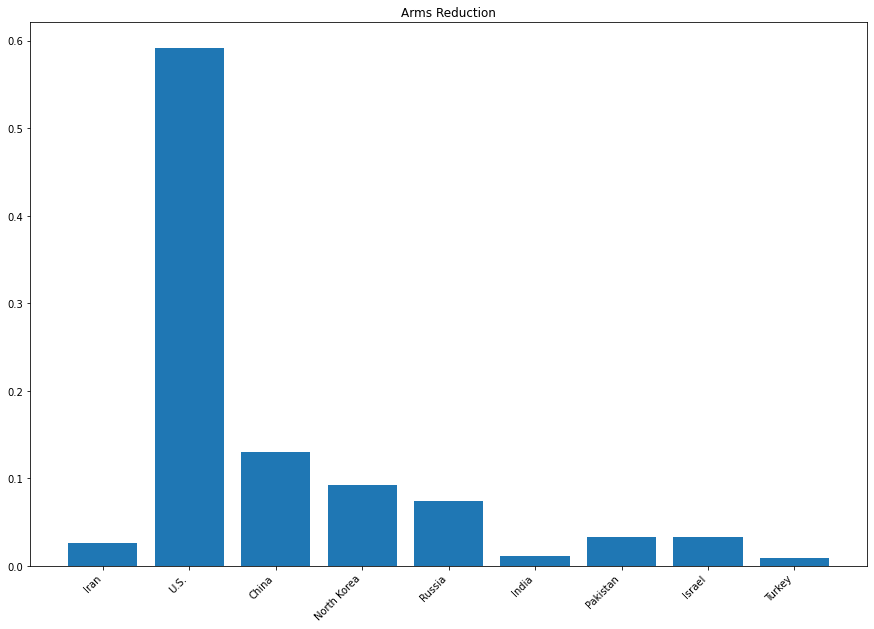

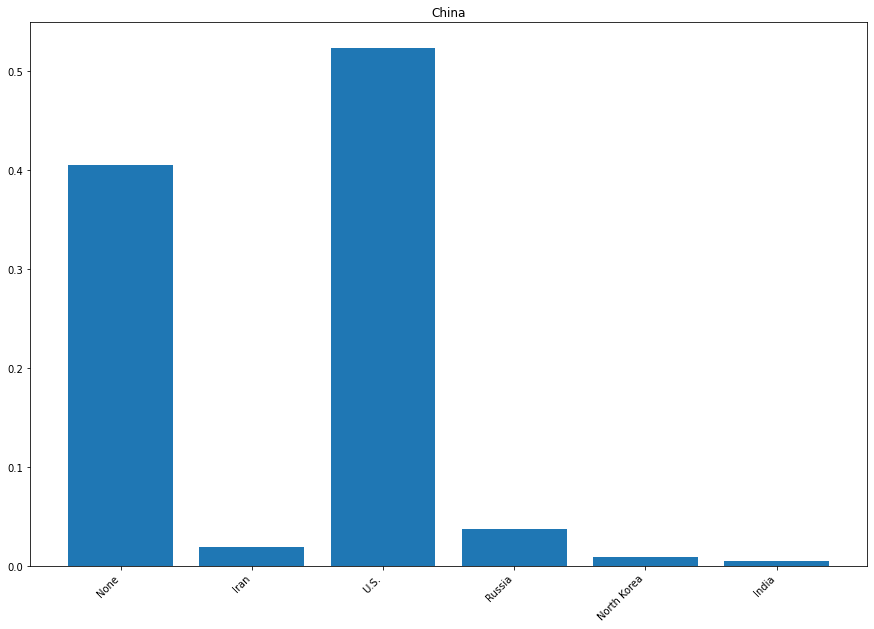

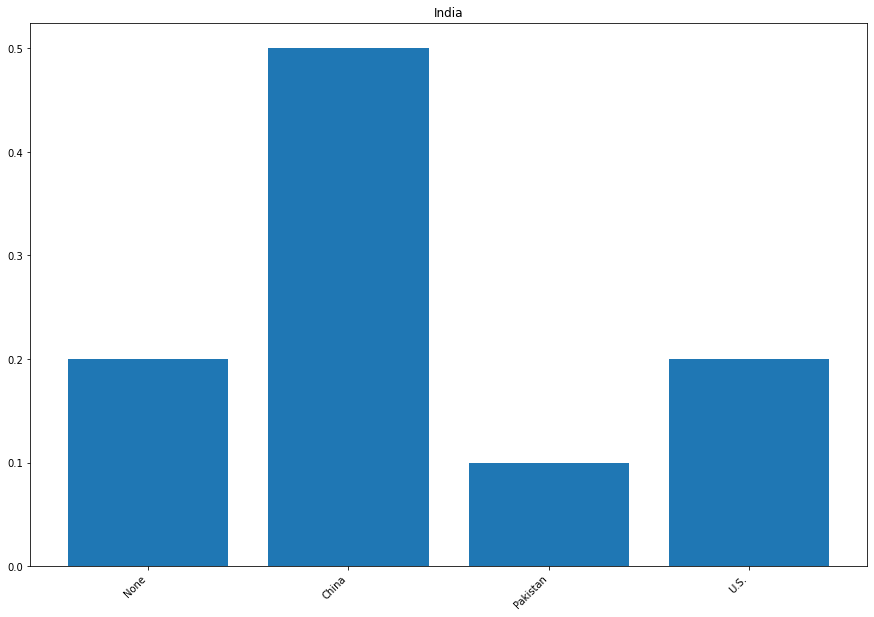

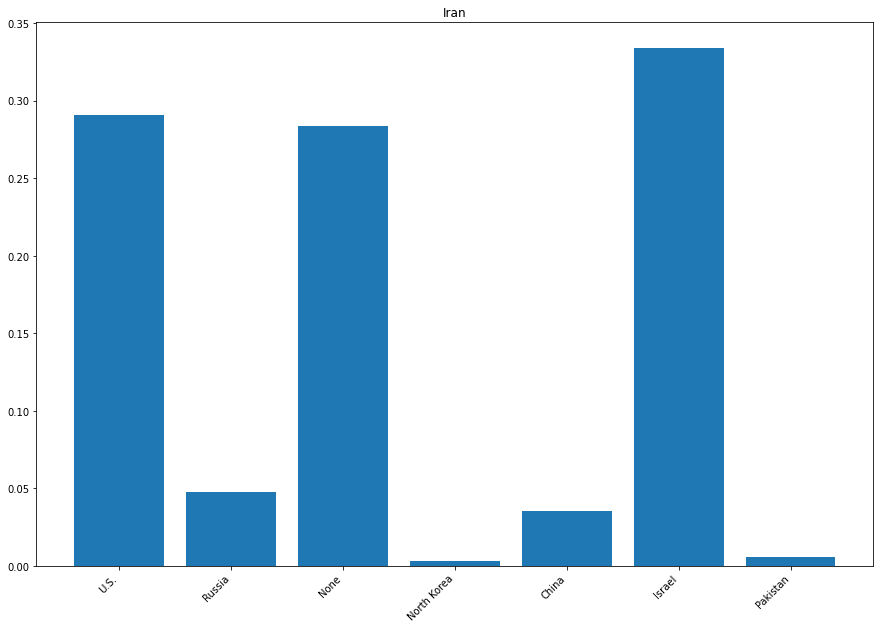

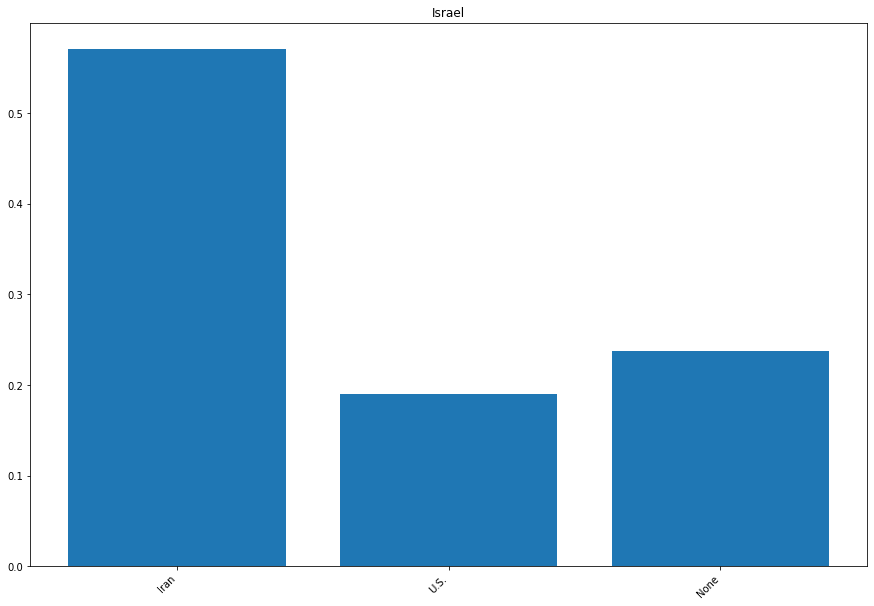

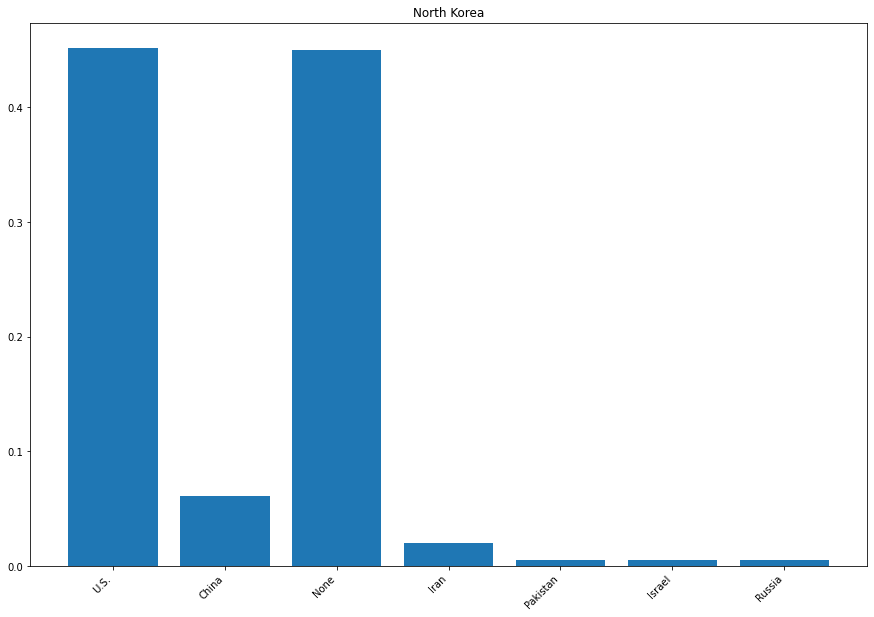

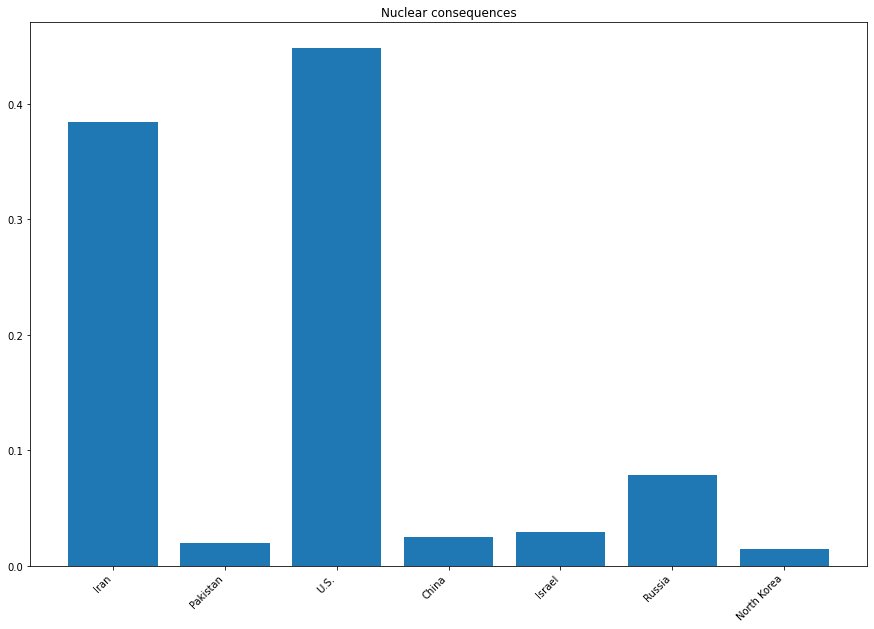

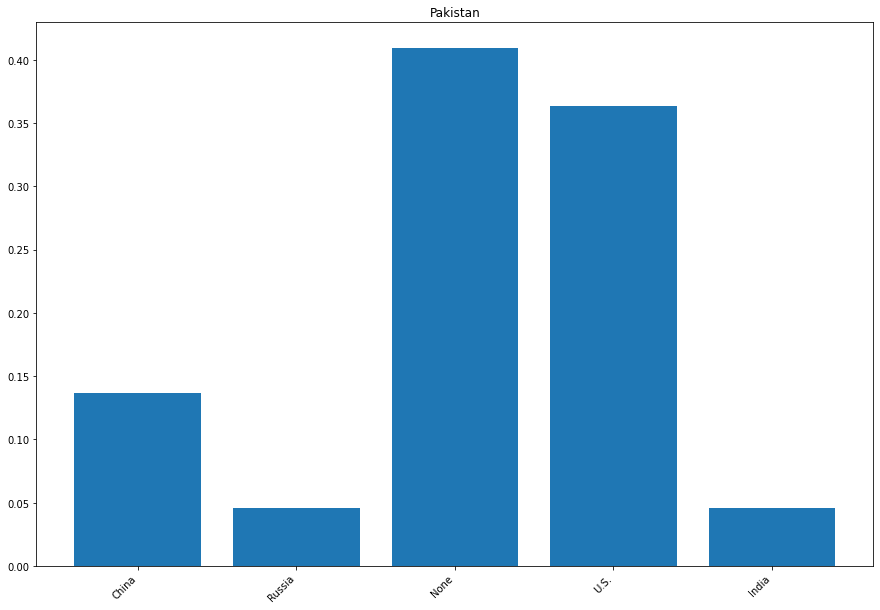

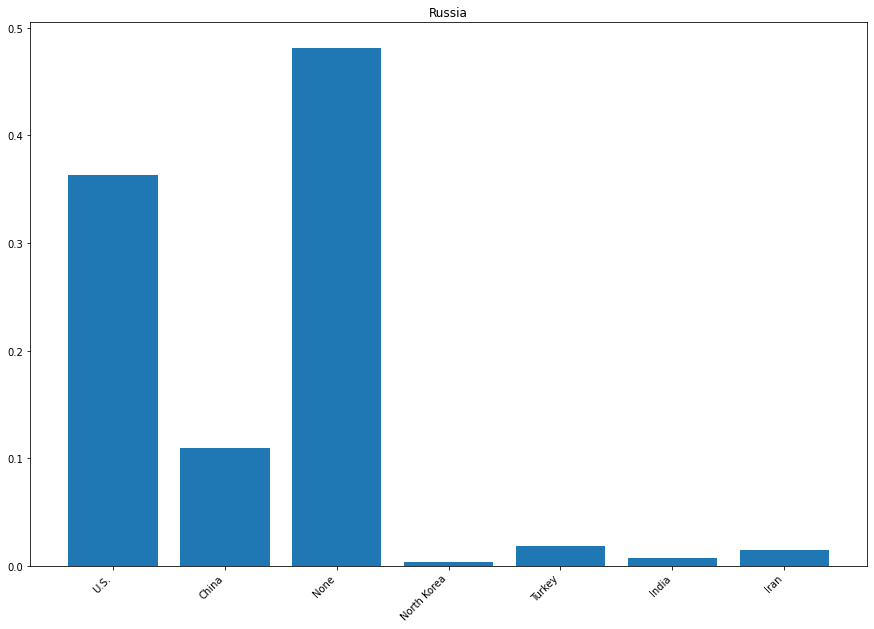

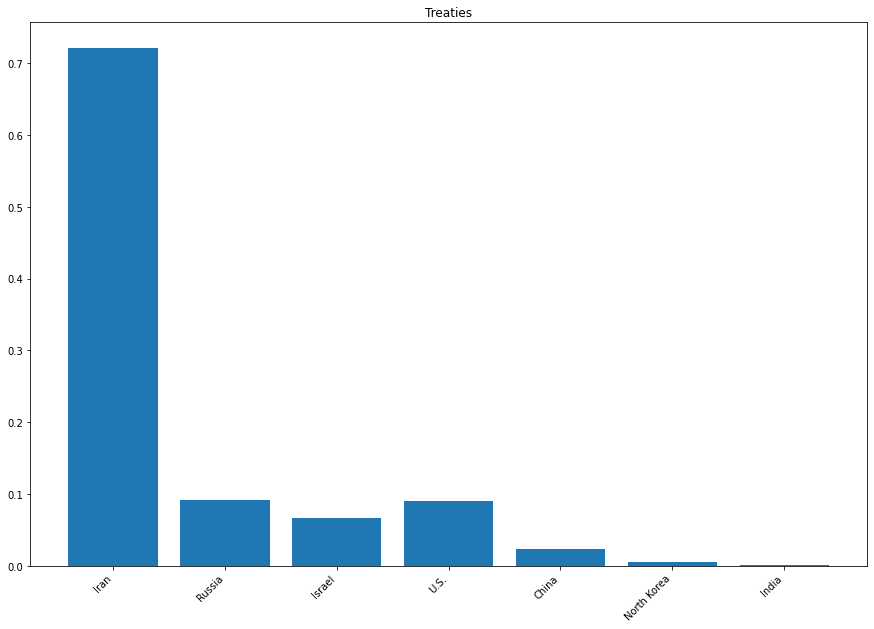

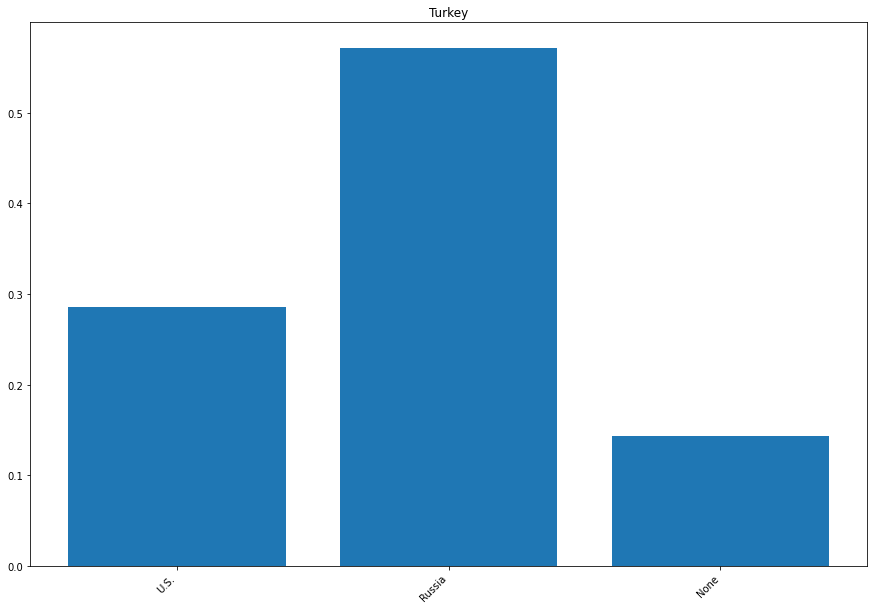

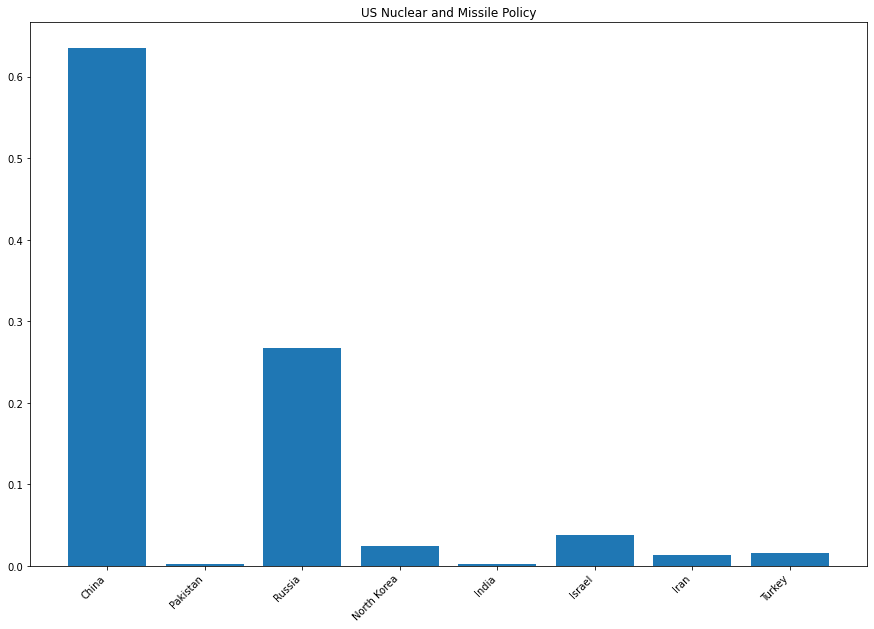

In [56]:
for index, row in misclassification_list.iterrows():
    country = index
    freq = row["message_wrong_frequencies"]
    freq_df = pd.DataFrame(freq.items())
    plt.figure(figsize=(15,10))
    plt.bar(freq_df[0].astype(str), freq_df[1].astype(np.float16))
    plt.title(country)
    plt.xticks(rotation=45, ha='right')

In [67]:
features_df_final = features_df[["Quote ID", "Messages", "most_frequent_country_3", "most_frequent_country_full", 
                             "most_frequent_headline", "max_frequency_context", "max_frequency_full", 
                             "max_frequency_headline", "majority"]]
features_df_final

,Quote ID,Messages,most_frequent_country_3,most_frequent_country_full,most_frequent_headline,max_frequency_context,max_frequency_full,max_frequency_headline,majority
0,58465753,US Nuclear and Missile Policy,U.S.,U.S.,None,1.00,1.000000,0.0,U.S.
1,58465751,US Nuclear and Missile Policy,U.S.,U.S.,None,1.00,1.000000,0.0,U.S.
2,58465752,US Nuclear and Missile Policy,None,U.S.,None,0.00,1.000000,0.0,None
3,58671291,Iran,Iran,Iran,Iran,0.75,0.619048,0.5,Iran
4,58465761,Iran,Iran,Iran,Iran,0.75,0.619048,0.5,Iran
...,...,...,...,...,...,...,...,...,...
14202,81036606,Russia,China,China,China,0.50,0.430769,1.0,China
14203,81036619,China,China,China,China,0.50,0.430769,1.0,China
14204,81036994,China,China,China,China,0.50,0.430769,1.0,China
14205,81036895,Russia,China,China,China,0.50,0.430769,1.0,China


In [68]:
features_df_final.to_csv("final_features_grace.csv", index = False)

## All countries

In [123]:
features_df["is_message_country"] = features_df["Messages"].apply(is_message_country)
df_all_country = features_df[(features_df["is_message_country"])]
df_all_country

/var/folders/x1/86vmscps1y511ryptj4pmd1w0000gn/T/ipykernel_60927/1796067978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df["is_message_country"] = features_df["Messages"].apply(is_message_country)


,Messages,most_frequent_country_3,most_frequent_country_full,most_frequent_headline,max_frequency_context,max_frequency_full,max_frequency_headline,diff_1_2_context,diff_1_2_full,message_equal_country_3,message_equal_headline,message_equal_country_full,majority,majority_correct,is_message_country
3,Iran,Iran,Iran,Iran,0.750000,0.619048,0.5,0.750000,0.619048,True,True,True,Iran,True,True
4,Iran,Iran,Iran,Iran,0.750000,0.619048,0.5,0.750000,0.619048,True,True,True,Iran,True,True
5,Iran,Iran,Iran,Iran,0.500000,0.619048,0.5,0.500000,0.619048,True,True,True,Iran,True,True
6,Iran,Iran,Iran,Iran,0.428571,0.619048,0.5,0.428571,0.619048,True,True,True,Iran,True,True
7,Iran,Iran,Iran,Iran,0.500000,0.619048,0.5,0.500000,0.619048,True,True,True,Iran,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14202,Russia,China,China,China,0.500000,0.430769,1.0,0.500000,0.430769,False,False,False,China,False,True
14203,China,China,China,China,0.500000,0.430769,1.0,0.500000,0.430769,True,True,True,China,True,True
14204,China,China,China,China,0.500000,0.430769,1.0,0.500000,0.430769,True,True,True,China,True,True
14205,Russia,China,China,China,0.500000,0.430769,1.0,0.500000,0.430769,False,False,False,China,False,True


In [124]:
df_country_is_message_3_all_country = df_all_country[(df_all_country["message_equal_country_3"])]
df_country_is_not_message_3_all_country = df_all_country[~(df_all_country["message_equal_country_3"])]

# proportions of values where message equal most frequent country
prop_country_equal_message_3_all_country = df_country_is_message_3_all_country.shape[0]/df_all_country.shape[0]
print(prop_country_equal_message_3_all_country)
prop_country_not_equal_message_3_all_country = df_country_is_not_message_3_all_country.shape[0]/df_all_country.shape[0]
print(prop_country_not_equal_message_3_all_country)

0.8032928010330356
0.19670719896696437


In [125]:
df_country_is_headline_all_country = df_all_country[(df_all_country["message_equal_headline"])]
df_country_is_not_headline_all_country = df_all_country[~(df_all_country["message_equal_headline"])]

# proportions of values where message equal most frequent country
prop_country_equal_headline_all_country = df_country_is_headline_all_country.shape[0]/df_all_country.shape[0]
print(prop_country_equal_headline_all_country)
prop_country_not_equal_headline_all_country = df_country_is_not_headline_all_country.shape[0]/df_all_country.shape[0]
print(prop_country_not_equal_headline_all_country)

0.7211879909609383
0.27881200903906167


In [126]:
df_country_is_message_full_all_country = df_all_country[(df_all_country["message_equal_country_full"])]
df_country_is_not_message_full_all_country = df_all_country[~(df_all_country["message_equal_country_full"])]

# proportions of values where message equal most frequent country
prop_country_equal_message_full_all_country = df_country_is_message_full_all_country.shape[0]/df_all_country.shape[0]
print(prop_country_equal_message_full_all_country)
prop_country_not_equal_message_full_all_country = df_country_is_not_message_full_all_country.shape[0]/df_all_country.shape[0]
print(prop_country_not_equal_message_full_all_country)

0.7997417410954482
0.20025825890455182


In [130]:
features_df = df_all_country[["Messages", "most_frequent_country_3", "most_frequent_country_full", 
                             "most_frequent_headline", "max_frequency_context", "max_frequency_full", 
                             "max_frequency_headline", "diff_1_2_context", "diff_1_2_full"]]
features_df.head()

,Messages,most_frequent_country_3,most_frequent_country_full,most_frequent_headline,max_frequency_context,max_frequency_full,max_frequency_headline,diff_1_2_context,diff_1_2_full
3,Iran,Iran,Iran,Iran,0.750000,0.619048,0.5,0.750000,0.619048
4,Iran,Iran,Iran,Iran,0.750000,0.619048,0.5,0.750000,0.619048
5,Iran,Iran,Iran,Iran,0.500000,0.619048,0.5,0.500000,0.619048
6,Iran,Iran,Iran,Iran,0.428571,0.619048,0.5,0.428571,0.619048
7,Iran,Iran,Iran,Iran,0.500000,0.619048,0.5,0.500000,0.619048


In [131]:
features_df["majority"] = features_df.apply(majority_from_context_3_full_headline, axis = 1)
features_df["majority_correct"] = features_df.apply(check_prediction, axis = 1)
df_country_is_majority = features_df[features_df["majority_correct"]]
df_country_is_not_majority = features_df[~features_df["majority_correct"]]

prop_country_equal_majority = df_country_is_majority.shape[0]/features_df.shape[0]
print(prop_country_equal_majority)
prop_country_not_equal_majority = df_country_is_not_majority.shape[0]/features_df.shape[0]
print(prop_country_not_equal_majority)

0.8097492736468309
0.19025072635316906


/var/folders/x1/86vmscps1y511ryptj4pmd1w0000gn/T/ipykernel_60927/3038893949.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df["majority"] = features_df.apply(majority_from_context_3_full_headline, axis = 1)
/var/folders/x1/86vmscps1y511ryptj4pmd1w0000gn/T/ipykernel_60927/3038893949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_df["majority_correct"] = features_df.apply(check_prediction, axis = 1)


## Next Steps
- combine with Atmika's features 
- play around with different models (ex. decision tree)
- look at other potential features?
    - something not related to frequency?